# Example Using Sycamore Quantum Circuit

Here we'll run through a more in-depth tensor contraction path finding, including all the different visualization options, by computing some amplitudes for random circuits on Google's Sycamore chip .  

In [1]:
import quimb.tensor as qtn
import cotengra as ctg

In [2]:
# just set up some misc notebook plotting stuff

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

Two Sycamore circuit definitions are included in this repository, the first of which ($m=10$) should fit into memory, and the second of which ($m=12$) will require *slicing*.

In [3]:
def load_circuit(
    n=53,
    depth=10,
    seed=0 ,
    elided=0,
    sequence='ABCDCDAB',
    swap_trick=False
):
    file = f'circuit_n{n}_m{depth}_s{seed}_e{elided}_p{sequence}.qsim'

    if swap_trick:
        gate_opts={'contract': 'swap-split-gate', 'max_bond': 2}  
    else:
        gate_opts={}
    
    # instantiate the `Circuit` object that 
    # constructs the initial tensor network:
    return qtn.Circuit.from_qasm_file(file, gate_opts=gate_opts)

Make our target tensor network the overlap of the wavefunction with a bitstring:

In [4]:
circ = load_circuit(depth=10)
psi_f = qtn.MPS_computational_state('0' * (circ.N))
tn = circ.psi & psi_f
output_inds = []

We can check out what the raw TN looks like:

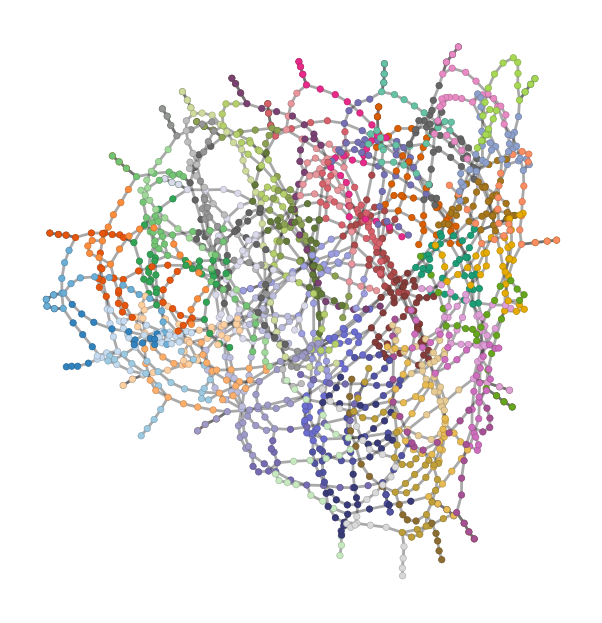

In [5]:
tn.graph(iterations=20, color=circ.psi.site_tags, legend=False, figsize=(3, 3))

As well as what it looks like after standard pre-processing:

In [6]:
# inplace full simplify and cast to single precision
tn.full_simplify_(output_inds=output_inds)
tn.astype_('complex64')

<TensorNetwork(tensors=164, indices=319, structure='I{}', nsites=53)>

The simplification uses some `numba` compiled functions which might slow things done first run.

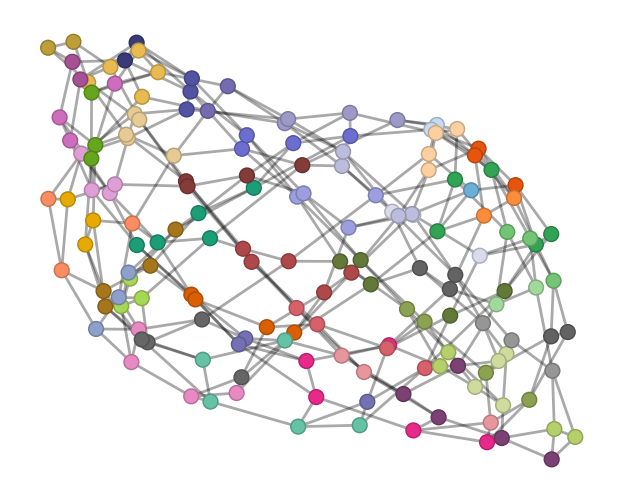

In [7]:
tn.graph(initial_layout='kamada_kawai', iterations=10, color=circ.psi.site_tags, legend=False, figsize=(3, 3))

Now we're ready to try and find a contraction path (various initializiation options are illustrated - not necessarily the best):

In [8]:
opt = ctg.HyperOptimizer(
    methods=['kahypar', 'greedy', 'walktrap'],
    max_repeats=128,
    progbar=True,
    minimize='flops',
    score_compression=0.5,  # deliberately make the optimizer try many methods 
)

The optimizer is stateful, so this following actual search call can be run repeatedly:

In [9]:
info = tn.contract(all, optimize=opt, get='path-info')

log2[SIZE]: 27.00 log10[FLOPs]: 10.34: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s]


We can visualize the progress of the Bayesian optimizer like so:

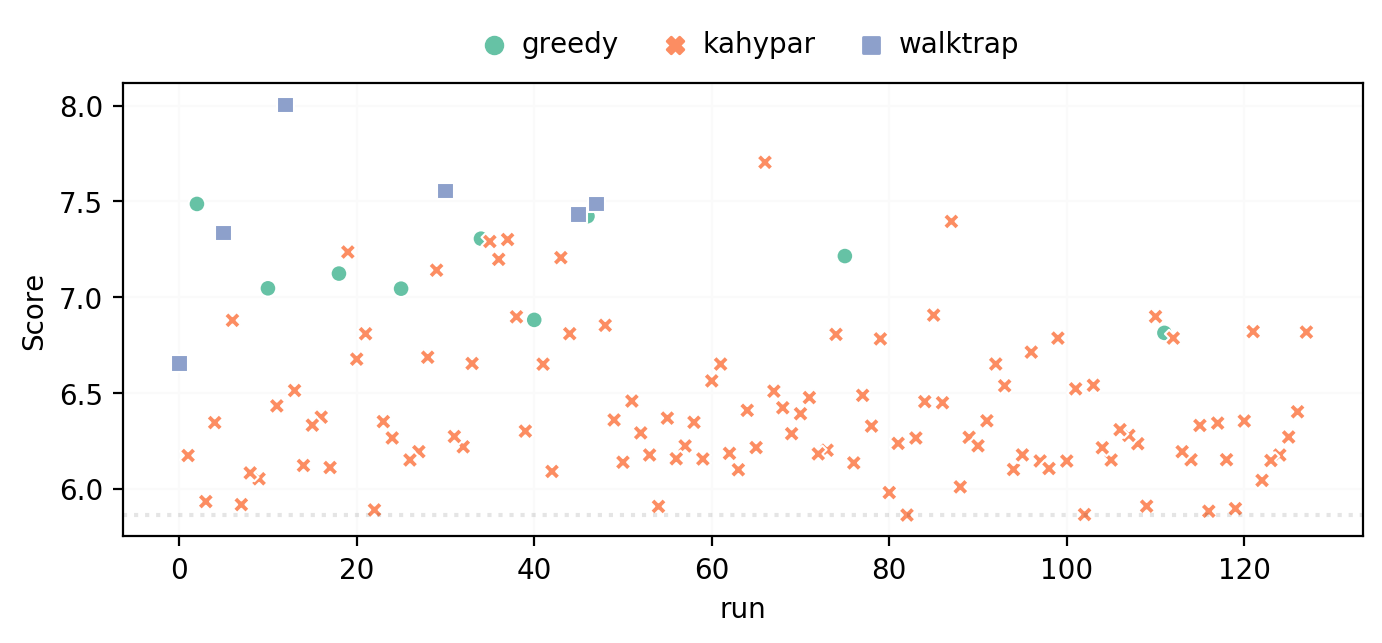

In [10]:
opt.plot_trials()

Clearly the `kahypar` optimizer seems to be able to find the lowest cost contractions.

We can also plot the relationship between contraction flops and size (the `minimize='combo'` score (log2[SIZE] + log2[FLOPS]) effectively ranks how close they are to the origin and can be useful to balance the two aims):

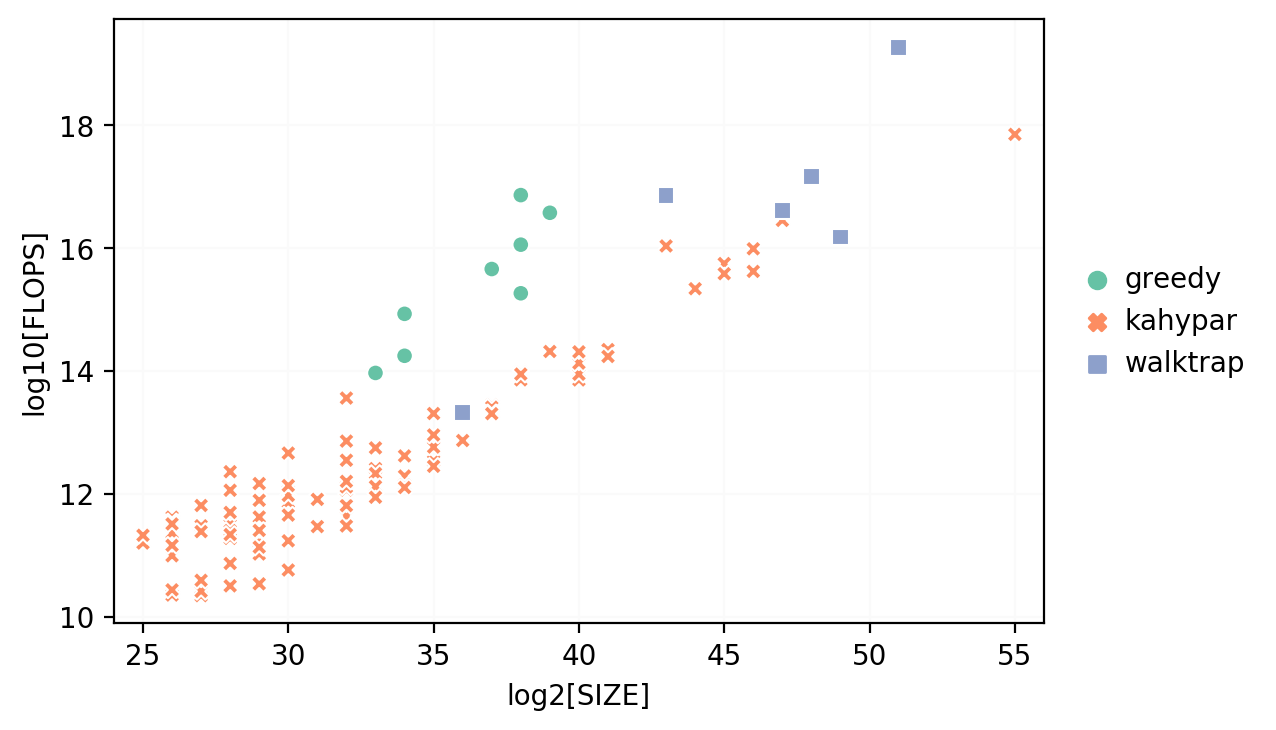

In [11]:
opt.plot_scatter()

Where it becomes apparent, that while correlated, the minimum size contraction found is not necessarily the same as the minimum cost contraction found.

If we want to visualize what the actual best contraction tree looks like we need to extract the `ContractionTree` object from the optimizer:

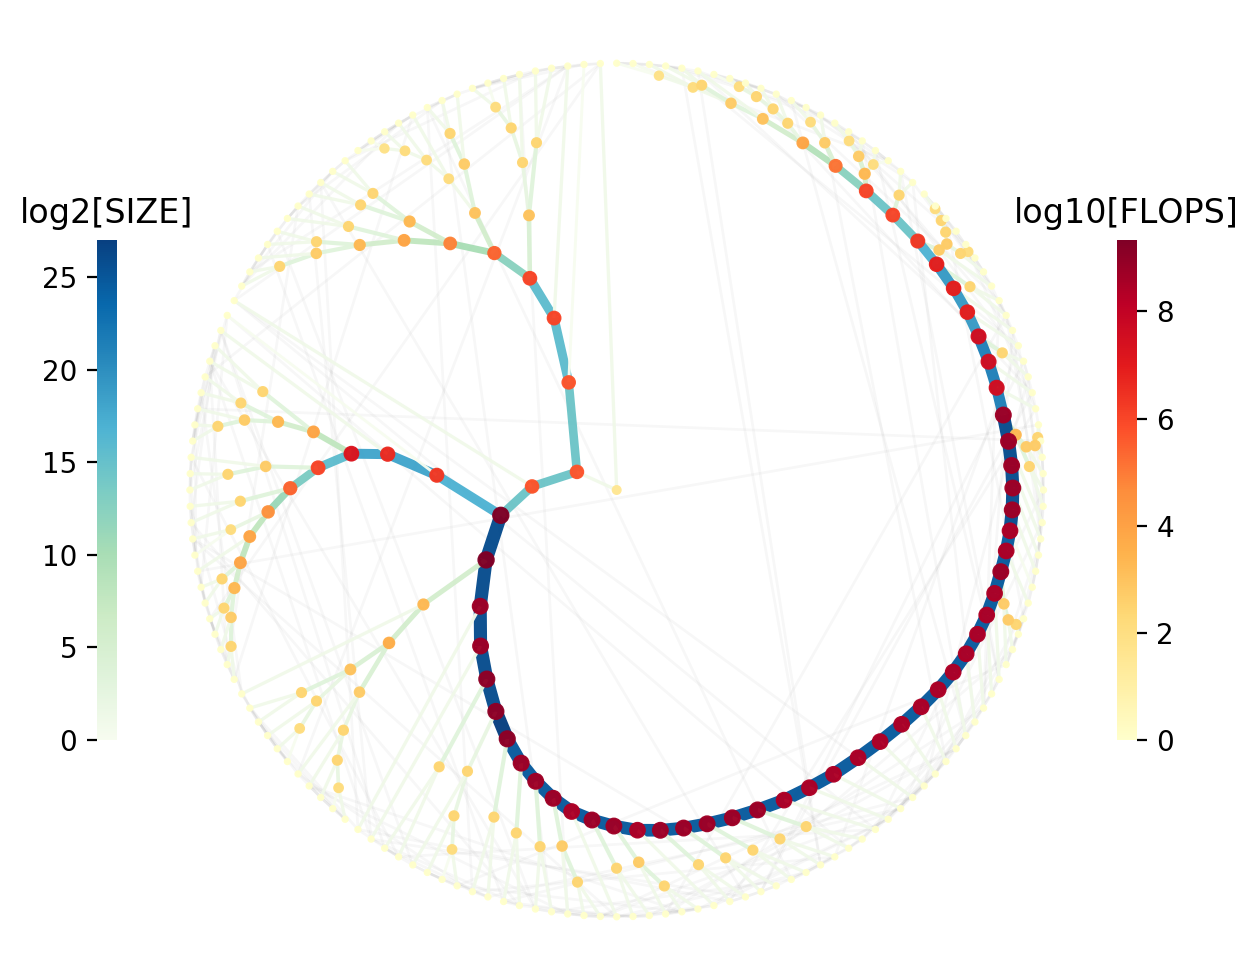

In [12]:
tree = opt.best['tree']
tree.plot_ring(node_scale= 1 / 3, edge_scale=2 / 3)

We can try and plot what this might look like on top of the TN graph arranged properly, though its likely messy...

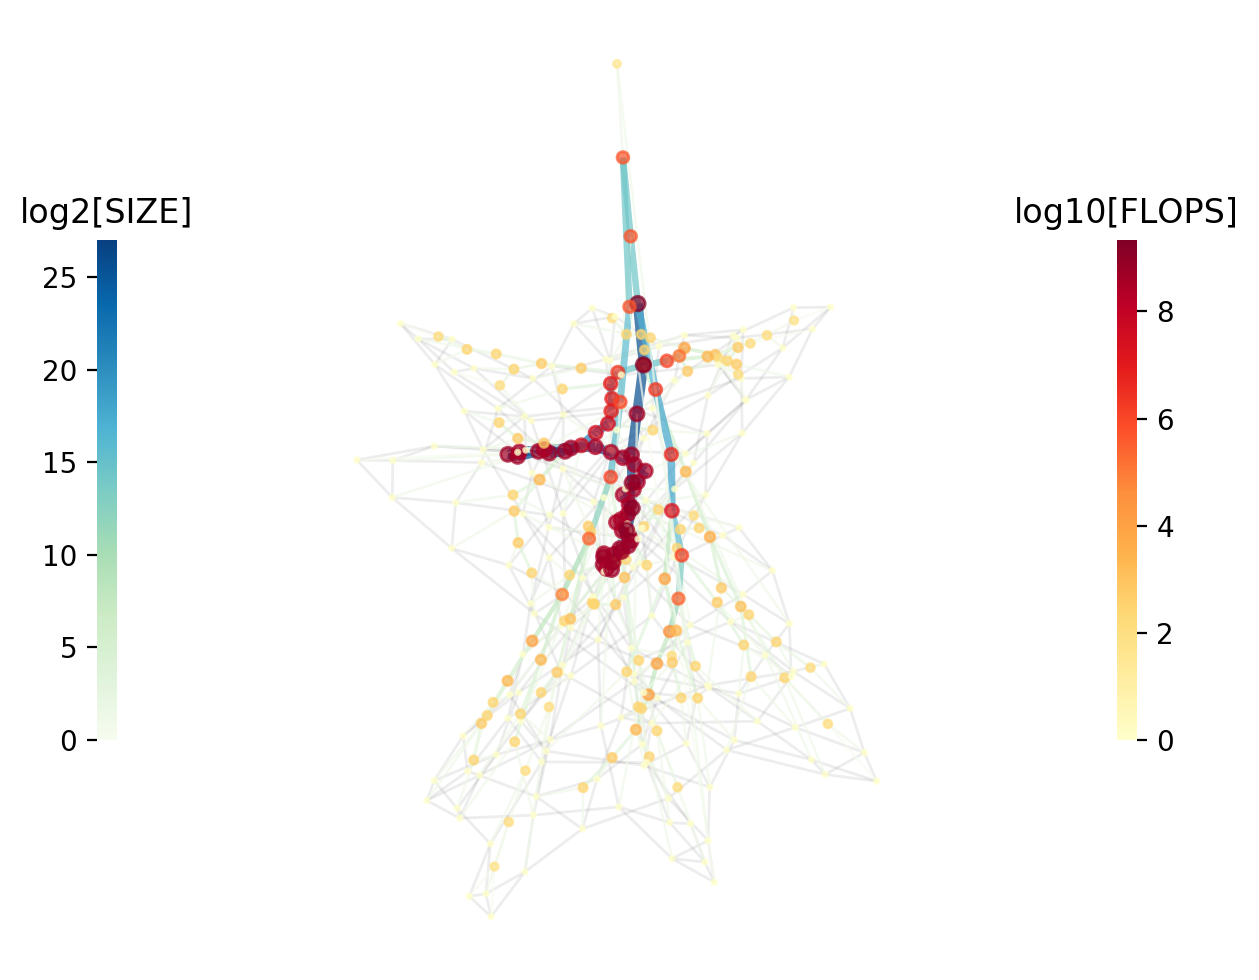

In [13]:
tree.plot_tent()

We can see that the contraction found is imbalanced, with small tensors being steadily absorbed into one big tensor.

One more plot function allows one to investigate the actual numbers involved:

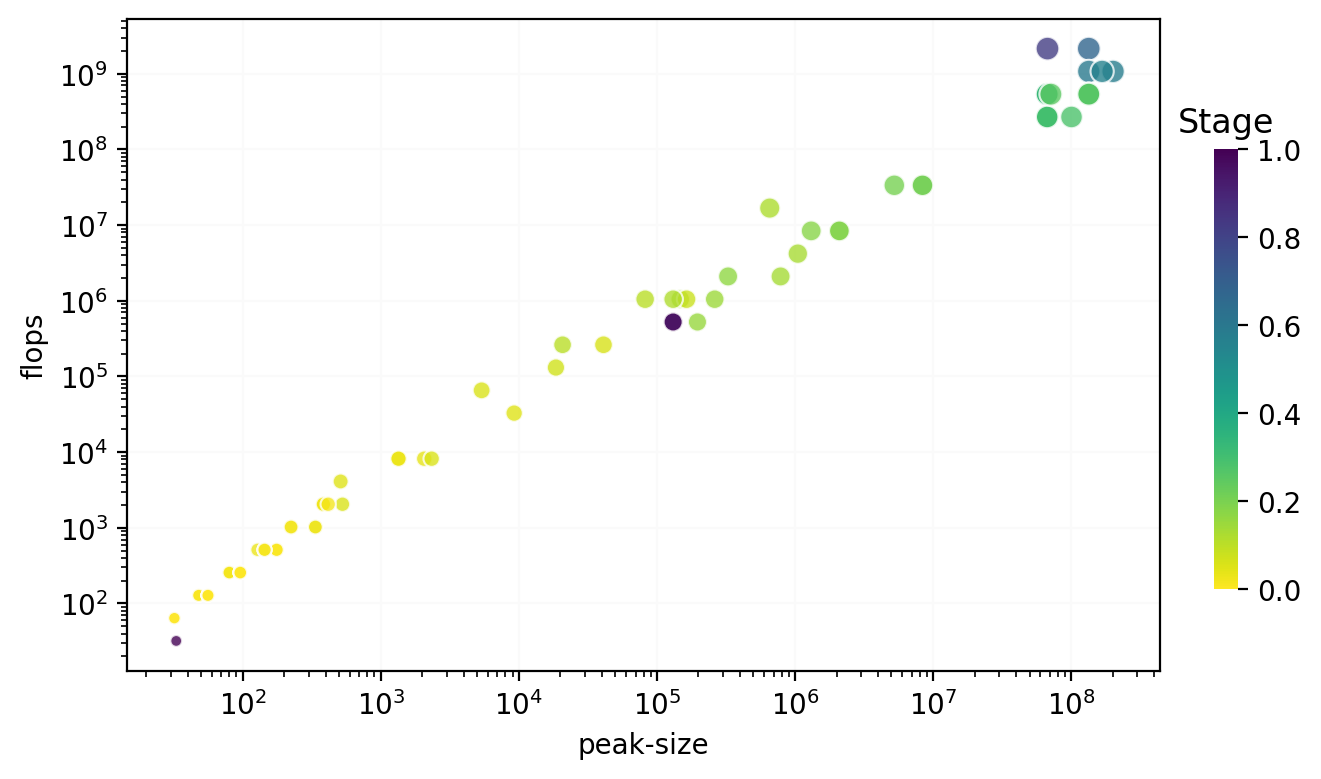

In [14]:
tree.plot_contractions()

Here, 'peak-size' is the memory required for both inputs and the output of each contraction.

Note again that 'flops' defined here assumes real data (as per `opt_einsum` convention), the 'cost' or number of scalar operations, $C$, is generally half this, whereas for quantum circuits with complex tensors, the real FLOPs will be 4x.

We can also actually perform the contraction. (The efficiency of of imbalanced contractions is quite bad for `numpy` and I'm running this example via WSL on a laptop so take actual timing with a large pinch of salt).

In [15]:
%%timeit
tn.contract(all, optimize=opt.path, backend='jax')

328 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


TN construction and simplification is determinstic in `quimb` so at least in this case we can easily evaluate another amplitude with the same contraction tree:

In [16]:
tn = (circ.psi & qtn.MPS_rand_computational_state(circ.N, seed=42))
tn.full_simplify_().astype_('complex64')

<TensorNetwork(tensors=164, indices=319, structure='I{}', nsites=53)>

In [17]:
%%time
tn.contract(all, optimize=opt.path, backend='jax')

CPU times: user 190 ms, sys: 145 ms, total: 335 ms
Wall time: 325 ms


(8.015539343375622e-10-1.0800241589947746e-08j)

# Searching for sliced contractions (Sycamore $m=12$)

To illustrate slicing we'll setup a (much harder!) depth 12 circuit. We'll perform a swapped rank-2 decomposition on the gates (for a not insignificant drop in total fidelity):

In [18]:
circ = load_circuit(depth=12, swap_trick=True)
sampler = qtn.MPS_computational_state('0' * (circ.N))
tn = circ.psi & sampler
tn.full_simplify_(output_inds=[])
tn.astype_('complex64')

<TensorNetwork(tensors=614, indices=409, structure='I{}', nsites=53)>

Because of the rank-2 swapped gate decomposition the full simplify function has now found hyperedge introducing diagonal reductions (which is why there are more tensors than indices).

Now when we intialize the hyper optimizer we'll tell it slice each contraction before reporting the cost and size. 

In [19]:
# we're going to help accelerate the optimizer search by restricting its search space, 
# since highly balanced contraction trees generally slice best:
ctg.hyper._HYPER_SEARCH_SPACE['kahypar']['imbalance']['max'] = 0.1

opt = ctg.HyperOptimizer(
    methods=['kahypar'],
    max_time=120,              # just search for 2 minutes
    max_repeats=1000,
    progbar=True,
    minimize='flops',
    slicing_opts={'target_size': 2**28}
)

In [20]:
# because of the hyperedges we need to specify no output indices
info = tn.contract(all, optimize=opt, get='path-info', output_inds=[])

log2[SIZE]: 28.00 log10[FLOPs]: 13.62:   8%|▊         | 76/1000 [02:00<24:24,  1.59s/it]  


Sliced contractions can be more difficult to find, if performance is critical its worth running this for longer, maybe with a large parallel pool supplied to the `parallel=` kwarg. 

We can see that all the contractions are now 'size 28' however:

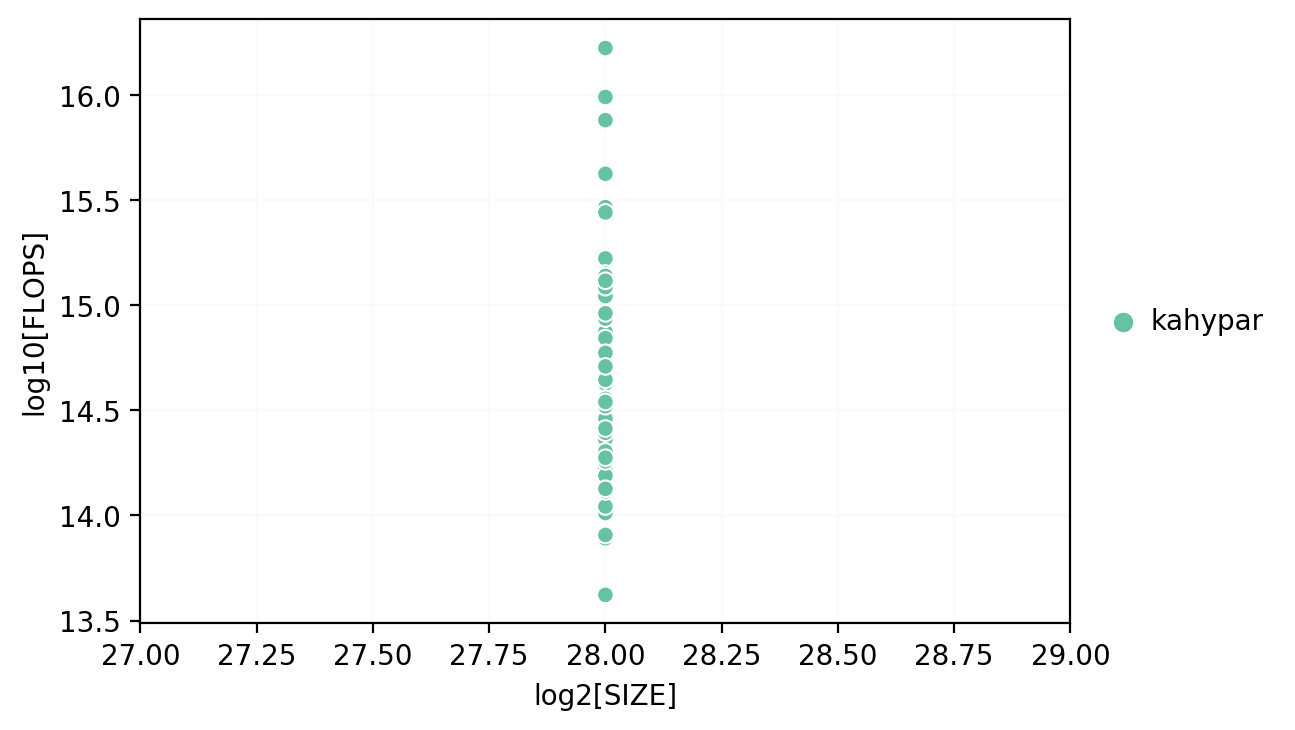

In [21]:
opt.plot_scatter()

We can check what this new contraction tree looks like:

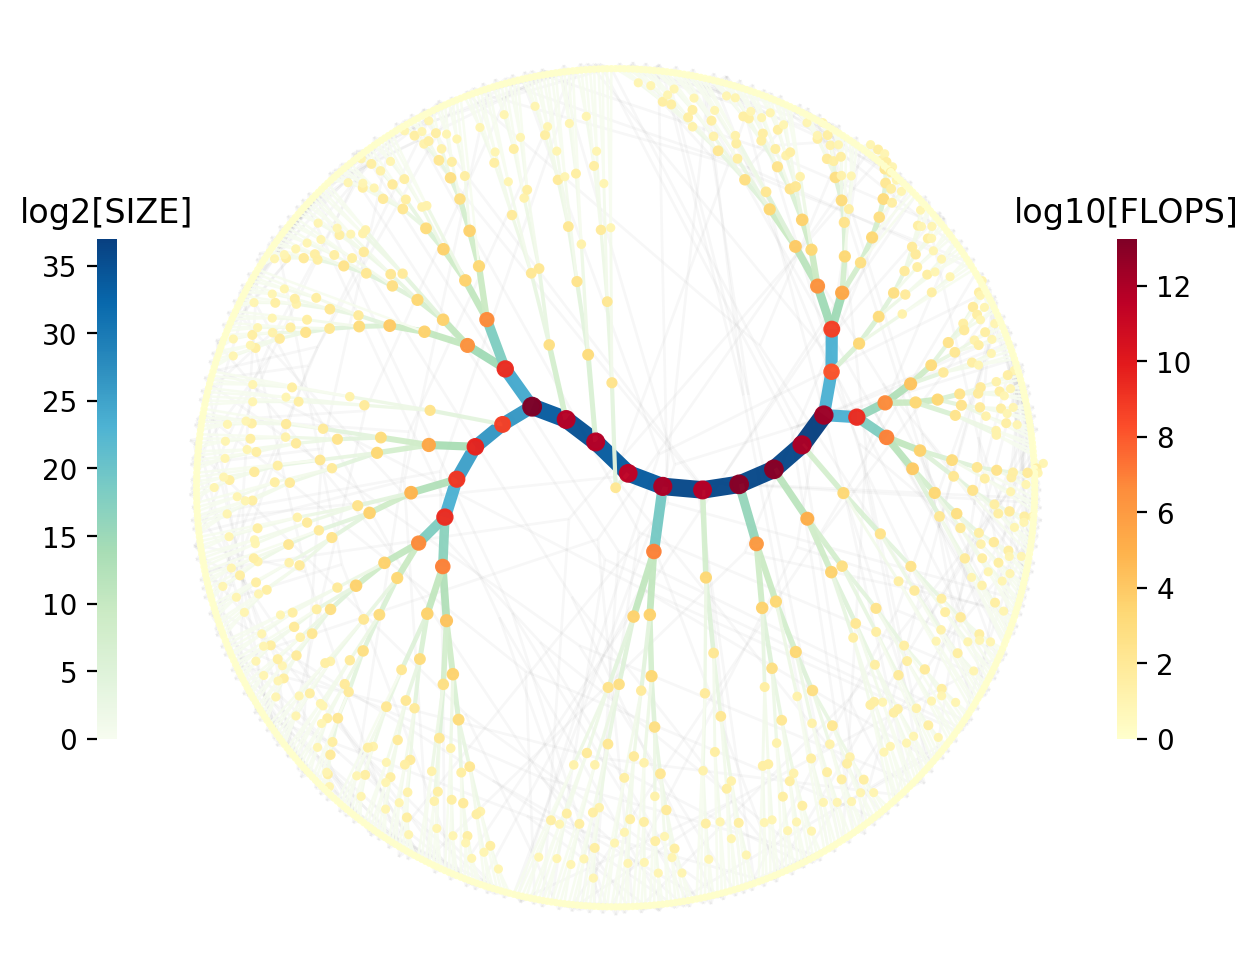

In [22]:
tree = opt.best['tree']
tree.plot_ring(node_scale=1 / 3, edge_scale=2 / 3)

As enforced, its now somewhat more balanced than the $m=10$ tree.

Now we are ready to search properly for the slicing indices, $2^{28}$ should be small enough to fit into no more than 8GB of memory.

In [23]:
sf = ctg.SliceFinder(info, target_size=2**28)

We can do quite thorough search with different levels of exploration:

In [24]:
ix_sl, cost_sl = sf.search(temperature=1.0)
ix_sl, cost_sl = sf.search(temperature=0.1)
ix_sl, cost_sl = sf.search(temperature=0.01)

We can also visualise what effect the slicing has had on the total cost (left - starting point, further to the right equals more sliced):

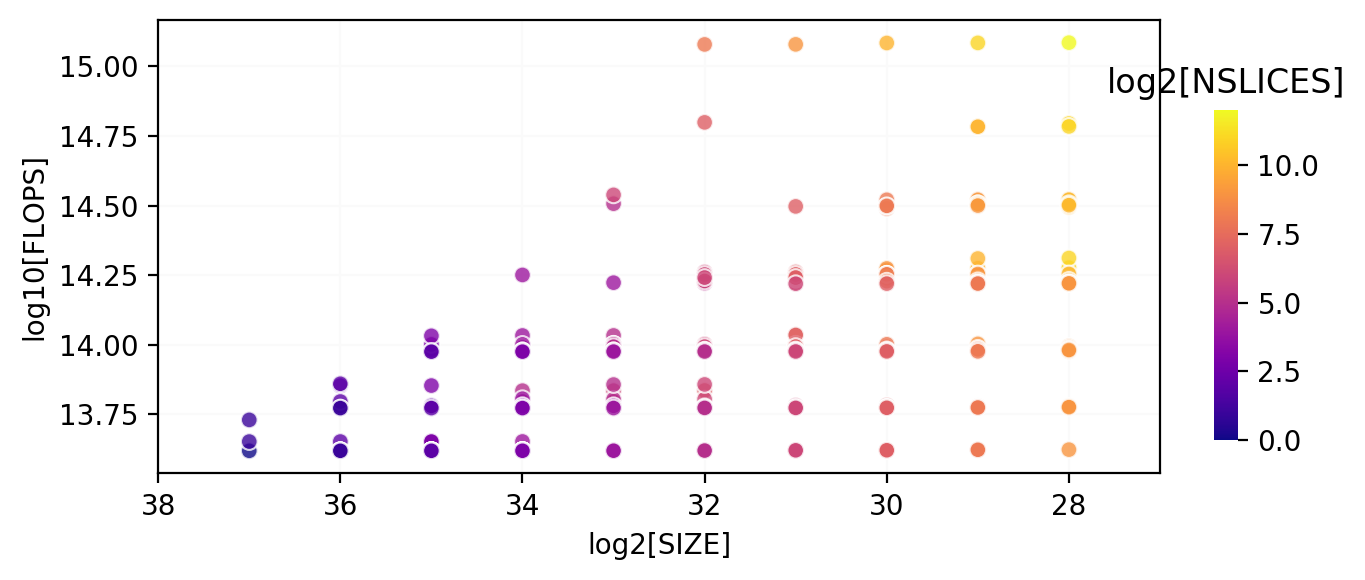

In [25]:
sf.plot_slicings(color_scheme='plasma')

Here there seems to have been very little theoretical overhead introduced by the slicing, *for this path*. The real slicing overhead is the increase in FLOPs in comparison to best unsliced path (likely v different).


## Performing the sliced contraction

The order of `quimb` tensors and their data is guaranteed to match that used by the `opt_einsum` syntax:

In [26]:
arrays = [t.data for t in tn] 
sc = sf.SlicedContractor(arrays)

Or we could translate the opt_einsum symbols back into `quimb` indices to handle the contractions in tensor network form (and use ``.cut_iter``).

In [27]:
[info.quimb_symbol_map[ix] for ix in ix_sl]

['_824ed50001128',
 '_824ed50000Fd8',
 '_824ed500013aE',
 '_824ed500013cc',
 '_824ed5000113C',
 '_824ed5000146b',
 '_824ed50001479',
 '_824ed50000EB1',
 '_824ed50001064']

The first time a contraction is run by `jax` with a particular shape its compiled, which can take a few seconds:

In [28]:
backend = 'jax'

In [29]:
%%time
c = sc.contract_slice(0, backend=backend)

CPU times: user 13.1 s, sys: 3.01 s, total: 16.1 s
Wall time: 17 s


However, the sliced contraction stores the compiled expression and reuses it for each slice:

In [30]:
import tqdm

In [31]:
for i in tqdm.tqdm(range(1, sc.nslices)):
    c = c + sc.contract_slice(i, backend=backend)

100%|██████████| 511/511 [07:51<00:00,  1.08it/s]


In [32]:
c

(5.700639e-09+4.9699285e-09j)

Again, the TN manipulations are deterministic so we can re-use everything:

In [33]:
tn = circ.psi & qtn.MPS_rand_computational_state(circ.N, seed=42)
tn.full_simplify_(output_inds=[]).astype_('complex64')

<TensorNetwork(tensors=614, indices=409, structure='I{}', nsites=53)>

In [34]:
# update the SlicedContractor's arrays
sc.arrays = tuple(t.data for t in tn)

# perform the contraction
sum(sc.contract_slice(i, backend=backend) for i in tqdm.tqdm(range(sc.nslices)))

100%|██████████| 512/512 [07:48<00:00,  1.09it/s]


(2.736300217659471e-09-2.170187640704313e-10j)